In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 128
IMAGE_SIZE = 128
CHANNELS = 1     # Grayscale
Z_DIM = 100      # Latent Vector Size
LR = 0.0002
EPOCHS = 100

Using device: cuda


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob

# --- CONFIGURATION ---
IMAGE_SIZE = 128
Z_DIM = 100
BATCH_SIZE = 64      # Reduced to 64 to save GPU memory with larger images
CHANNELS = 1         # Set to 1 for Grayscale, 3 for RGB Color
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GoodImagesDataset(Dataset):
    def __init__(self, root_dir):
        self.image_paths = glob.glob(os.path.join(root_dir, 'good', '*.*'))
        
        self.transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),     
            transforms.CenterCrop(IMAGE_SIZE), 
            transforms.ToTensor(),
            transforms.Normalize([0.5] * CHANNELS, [0.5] * CHANNELS)
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            # Convert to 'L' for Grayscale or 'RGB' for Color
            mode = 'L' if CHANNELS == 1 else 'RGB'
            image = Image.open(img_path).convert(mode)
            return self.transform(image)
        except Exception as e:
            return torch.zeros((CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

# Initialize Data
dataset = GoodImagesDataset(root_dir='/kaggle/input/anamoly-detection-dataset/anomaly_detection_test_data')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

--- DATASET ANALYSIS ---
Total Images found: 4157
Batch Shape: torch.Size([64, 1, 128, 128]) (Batch, Channels, Height, Width)
Value Range: Min -0.91, Max 1.00


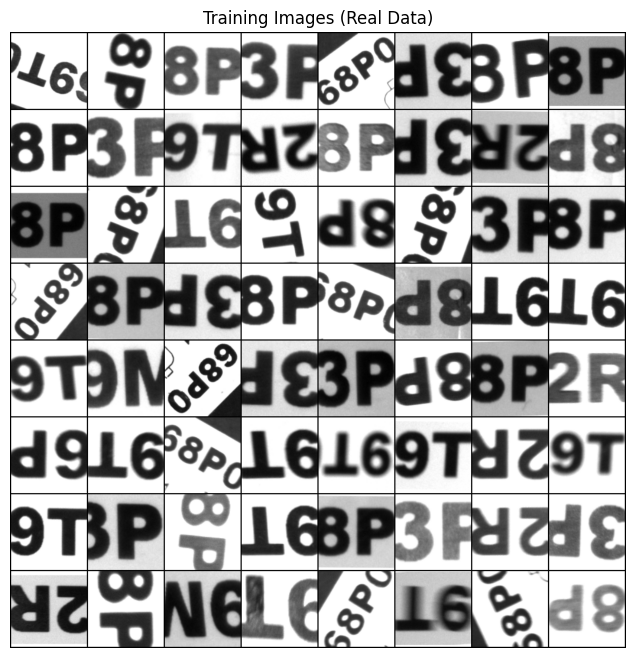

------------------------


In [4]:
print("--- DATASET ANALYSIS ---")
# 1. Fetch a single batch of real images
real_batch = next(iter(dataloader))

# 2. Print shape details
print(f"Total Images found: {len(dataset)}")
print(f"Batch Shape: {real_batch.shape} (Batch, Channels, Height, Width)")
print(f"Value Range: Min {real_batch.min():.2f}, Max {real_batch.max():.2f}")

# 3. Visualize the Real Data
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images (Real Data)")
# Make a grid, un-normalize (-1, 1) -> (0, 1), and reorder dims for matplotlib
grid_img = vutils.make_grid(real_batch[:64], padding=2, normalize=True).cpu()
plt.imshow(np.transpose(grid_img, (1, 2, 0)))
plt.show() 
print("------------------------")

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            # Layer 1: Output 4x4
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # Layer 2: Output 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # Layer 3: Output 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Layer 4: Output 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Layer 5: Output 64x64
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # Layer 6: Output 128x128
            nn.ConvTranspose2d(32, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels x 128 x 128
            # Layer 1: Output 64x64
            nn.Conv2d(channels, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 2: Output 32x32
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3: Output 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4: Output 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 5: Output 4x4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 6: Output 1x1 (Scalar probability)
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)

In [7]:
# Create Models
netG = Generator(Z_DIM, CHANNELS).to(device)
netD = Discriminator(CHANNELS).to(device)

# Weights Initialization function (Standard for DCGAN)
def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

print(f"Models initialized for {IMAGE_SIZE}x{IMAGE_SIZE} images.")

Models initialized for 128x128 images.


In [8]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

# Fixed noise to visualize the SAME seed improving over time
fixed_noise = torch.randn(64, Z_DIM, 1, 1, device=device)

Starting Training...
Epoch [1/100] Loss_D: 0.0034 Loss_G: 35.6218
Epoch [2/100] Loss_D: 0.1053 Loss_G: 4.8443
Epoch [3/100] Loss_D: 0.0858 Loss_G: 6.2075
Epoch [4/100] Loss_D: 0.1804 Loss_G: 4.0558
Epoch [5/100] Loss_D: 0.2318 Loss_G: 3.0597
Epoch [6/100] Loss_D: 0.2624 Loss_G: 3.0634
Epoch [7/100] Loss_D: 0.1473 Loss_G: 3.7173
Epoch [8/100] Loss_D: 0.2681 Loss_G: 3.1082
Epoch [9/100] Loss_D: 0.1776 Loss_G: 3.6749
Epoch [10/100] Loss_D: 0.3404 Loss_G: 6.4258
Epoch [11/100] Loss_D: 0.4327 Loss_G: 4.4060
Epoch [12/100] Loss_D: 0.1704 Loss_G: 3.0029
Epoch [13/100] Loss_D: 0.1029 Loss_G: 3.9217
Epoch [14/100] Loss_D: 0.1045 Loss_G: 3.9853
Epoch [15/100] Loss_D: 1.4043 Loss_G: 0.3338
Epoch [16/100] Loss_D: 0.1224 Loss_G: 3.8381
Epoch [17/100] Loss_D: 0.0853 Loss_G: 3.5865
Epoch [18/100] Loss_D: 0.1108 Loss_G: 3.6034
Epoch [19/100] Loss_D: 0.1231 Loss_G: 3.4009
Epoch [20/100] Loss_D: 0.1405 Loss_G: 3.7670
Epoch [21/100] Loss_D: 0.1505 Loss_G: 2.9473
Epoch [22/100] Loss_D: 0.1012 Loss_G: 4.09

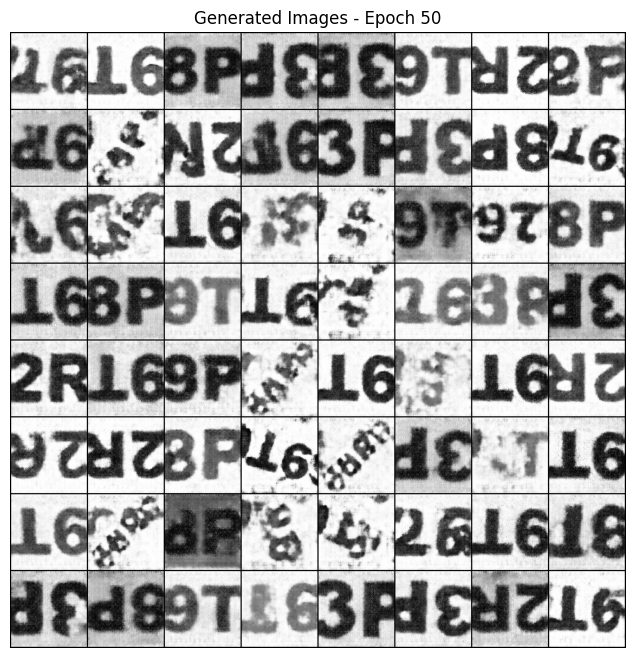

Epoch [51/100] Loss_D: 0.0751 Loss_G: 4.6025
Epoch [52/100] Loss_D: 0.0675 Loss_G: 4.4708
Epoch [53/100] Loss_D: 0.0291 Loss_G: 5.2113
Epoch [54/100] Loss_D: 0.0606 Loss_G: 4.2112
Epoch [55/100] Loss_D: 0.0330 Loss_G: 5.0493
Epoch [56/100] Loss_D: 0.2083 Loss_G: 2.9224
Epoch [57/100] Loss_D: 0.0736 Loss_G: 4.6585
Epoch [58/100] Loss_D: 0.0555 Loss_G: 4.3921
Epoch [59/100] Loss_D: 0.0288 Loss_G: 5.4098
Epoch [60/100] Loss_D: 0.0531 Loss_G: 4.5182
Epoch [61/100] Loss_D: 0.0287 Loss_G: 5.1220
Epoch [62/100] Loss_D: 4.1586 Loss_G: 0.9510
Epoch [63/100] Loss_D: 0.0556 Loss_G: 4.8443
Epoch [64/100] Loss_D: 0.0211 Loss_G: 5.7516
Epoch [65/100] Loss_D: 0.0979 Loss_G: 4.5048
Epoch [66/100] Loss_D: 0.0432 Loss_G: 4.9528
Epoch [67/100] Loss_D: 0.0783 Loss_G: 4.1863
Epoch [68/100] Loss_D: 0.1281 Loss_G: 3.6103
Epoch [69/100] Loss_D: 0.0525 Loss_G: 5.3179
Epoch [70/100] Loss_D: 0.5453 Loss_G: 4.2856
Epoch [71/100] Loss_D: 0.0066 Loss_G: 7.6405
Epoch [72/100] Loss_D: 0.2936 Loss_G: 5.9872
Epoch [73/

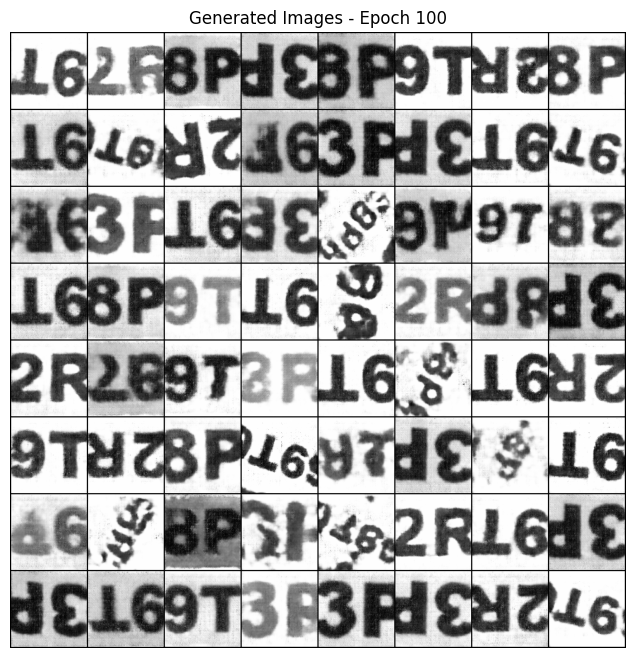

Training Finished.


In [9]:
print("Starting Training...")

for epoch in range(EPOCHS):
    for i, data in enumerate(dataloader):
        # 1. Train Discriminator
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        # 2. Train Generator
        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    # --- LOGGING ---
    # Print loss every epoch so you know the training is alive
    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')
    
    # --- VISUALIZATION (Every 50 Epochs) ---
    # (epoch + 1) % 50 == 0 ensures it runs on epoch 50, 100, 150, etc.
    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            # Generate fake images using the fixed noise
            fake_display = netG(fixed_noise).detach().cpu()
        
        # Plotting
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Generated Images - Epoch {epoch+1}")
        plt.imshow(np.transpose(vutils.make_grid(fake_display, padding=2, normalize=True), (1,2,0)))
        plt.show() 

print("Training Finished.")

In [10]:
# Save the Generator's state dictionary (weights)
torch.save(netG.state_dict(), 'generator_model.pth')

# Optional: Save Discriminator too (useful if you want to resume training later)
torch.save(netD.state_dict(), 'discriminator_model.pth')

print("Models saved successfully!")

Models saved successfully!


In [11]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import os

# --- CONFIG ---
TARGET_GOOD_IMAGES = 500
CONFIDENCE_THRESHOLD = 0.8 
Z_DIM = 100
CHANNELS = 1  # Ensure this matches your training (1 for grayscale, 3 for RGB)
OUTPUT_FOLDER = 'generated_128_images'
GEN_PATH = 'generator_model.pth'
DISC_PATH = 'discriminator_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x): return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, 32, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x).view(-1, 1).squeeze(1)

# --- LOAD & GENERATE ---
netG = Generator(Z_DIM, CHANNELS).to(device)
netD = Discriminator(CHANNELS).to(device)

if os.path.exists(GEN_PATH):
    netG.load_state_dict(torch.load(GEN_PATH, map_location=device))
    netD.load_state_dict(torch.load(DISC_PATH, map_location=device))
    netG.eval()
    netD.eval()
else:
    raise FileNotFoundError("Run the training loop first!")

if not os.path.exists(OUTPUT_FOLDER): os.makedirs(OUTPUT_FOLDER)

saved_count = 0
print("Generating images...")

while saved_count < TARGET_GOOD_IMAGES:
    with torch.no_grad():
        noise = torch.randn(64, Z_DIM, 1, 1, device=device)
        fake_images = netG(noise)
        scores = netD(fake_images)
        
        # Filter
        good_indices = (scores > CONFIDENCE_THRESHOLD).nonzero(as_tuple=True)[0]
        
        for idx in good_indices:
            if saved_count >= TARGET_GOOD_IMAGES: break
            vutils.save_image(fake_images[idx], f"{OUTPUT_FOLDER}/img_{saved_count:04d}.png", normalize=True)
            saved_count += 1
            if saved_count % 50 == 0: print(f"Saved {saved_count} images...")

print(f"Done! 500 images saved to {OUTPUT_FOLDER}")

Generating images...
Saved 50 images...
Saved 100 images...
Saved 150 images...
Saved 200 images...
Saved 250 images...
Saved 300 images...
Saved 350 images...
Saved 400 images...
Saved 450 images...
Saved 500 images...
Done! 500 images saved to generated_128_images
